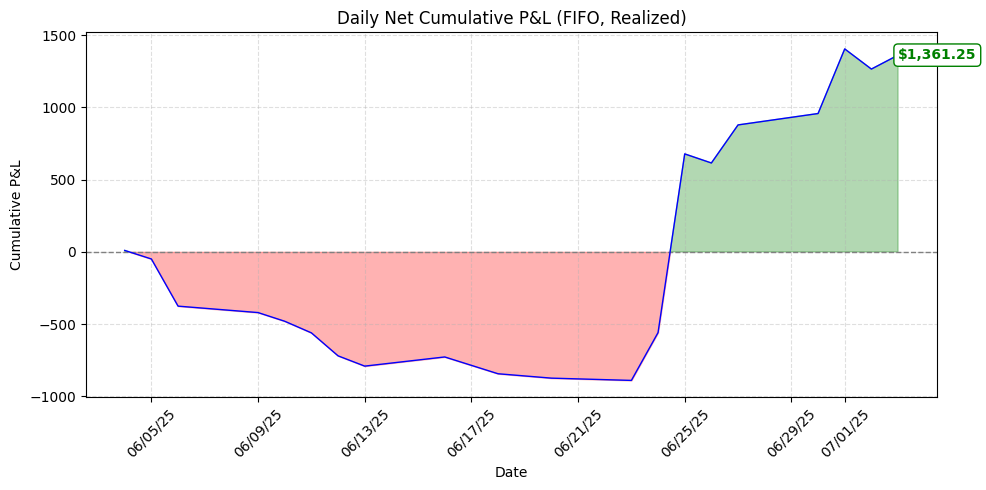

In [19]:
# Process Webull trade order data for KPIs
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil import parser
from collections import deque
from IPython.display import display, HTML

# Load & sort
orders_df = pd.read_csv('~/Downloads/Webull_Orders_Records_new.csv')
orders_df['Filled Time'] = orders_df['Filled Time'].apply(lambda x: parser.parse(x).astimezone(tz=None))
orders_df.sort_values(by=['Symbol', 'Filled Time'], inplace=True)

def group_trades(df):
    """
    Groups orders into complete round‐trip trades per symbol using FIFO matching.
    Returns a DataFrame with one row per closed trade.
    """
    df = df.copy()
    df['signed_qty'] = df['Filled'].where(df['Side']=='Buy', -df['Filled'])
    df['cum_qty'] = df.groupby('Symbol')['signed_qty'].cumsum()
    df['prev_cum'] = df.groupby('Symbol')['cum_qty'].shift(fill_value=0)
    tol = 1e-6
    df['is_entry'] = (df['prev_cum'].abs() < tol) & (df['signed_qty'] != 0)
    df['Trade ID'] = df.groupby('Symbol')['is_entry'].cumsum() - 1

    trades = []
    for (sym, tid), grp in df.groupby(['Symbol','Trade ID'], sort=False):
        fifo = deque()
        for _, row in grp.iterrows():
            qty, price, time = row['Filled'], row['Avg Price'], row['Filled Time']
            if row['Side'] == 'Buy':
                fifo.append([qty, price, time])
            else:
                rem = qty
                while rem > 0 and fifo:
                    b_qty, b_price, b_time = fifo[0]
                    m = min(b_qty, rem)
                    pnl = m * (price - b_price)
                    trades.append({
                        'Ticker':    sym,
                        'Trade ID':  tid,
                        'Quantity':  m,
                        'Buy Price': b_price,
                        'Sell Price':price,
                        'Open Date': b_time,
                        'Close Date':time,
                        'P&L':       pnl
                    })
                    if b_qty > m:
                        fifo[0][0] -= m
                    else:
                        fifo.popleft()
                    rem -= m

    trades_df = pd.DataFrame(trades)
    summary = trades_df.groupby(['Ticker','Trade ID']).agg(
        Quantity             = ('Quantity','sum'),
        Average_Buy_Price    = ('Buy Price','mean'),
        Average_Sell_Price   = ('Sell Price','mean'),
        Open_Date            = ('Open Date','min'),
        Close_Date           = ('Close Date','max'),
        PnL                  = ('P&L','sum')
    ).reset_index()

    return summary

# Usage:
CSV_PATH = '~/Downloads/webull_grouped_trades_summary.csv'
grouped_trades_df = group_trades(orders_df)
grouped_trades_df.to_csv(CSV_PATH, index=False)

# Calculate KPIs from grouped trades
tz = pd.read_csv(CSV_PATH)
pnl = tz['PnL'].astype(float)
wins   = pnl[pnl > 0]
losses = pnl[pnl < 0]

trade_cnt   = len(wins) + len(losses)
net_pl      = pnl.sum()
win_rate    = len(wins) / trade_cnt
profit_fact = wins.sum() / abs(losses.sum())
avg_win     = wins.mean()
avg_loss    = abs(losses.mean())

# --------- Reconstruct FIFO-matched trades (partial closes included) ---------
def reconstruct_fifo_trades(df):
    df = df.copy()
    df.sort_values(by='Filled Time', inplace=True)
    trades = []
    pos = {}
    lots = {}

    for _, row in df.iterrows():
        sym, qty, price, side, time = row['Symbol'], row['Filled'], row['Avg Price'], row['Side'], row['Filled Time']
        qty = float(qty)

        if sym not in pos:
            pos[sym] = 0
            lots[sym] = deque()

        if side == 'Buy':
            pos[sym] += qty
            lots[sym].append([qty, price, time])
        else:
            pos[sym] -= qty
            rem = qty
            while rem > 0 and lots[sym]:
                b_qty, b_price, b_time = lots[sym][0]
                m = min(b_qty, rem)
                pnl = m * (price - b_price)
                trades.append({
                    'Symbol': sym,
                    'Quantity': m,
                    'Buy Price': b_price,
                    'Sell Price': price,
                    'Open Time': b_time,
                    'Close Time': time,
                    'P&L': pnl
                })
                if b_qty > m:
                    lots[sym][0][0] -= m
                else:
                    lots[sym].popleft()
                rem -= m

    return pd.DataFrame(trades)

fifo_trades_df = reconstruct_fifo_trades(orders_df)

# --------- Plot true cumulative P&L (TradeZella-style logic) -----------
fifo_trades_df['Close Time'] = pd.to_datetime(fifo_trades_df['Close Time'])
daily_pnl = fifo_trades_df.groupby(fifo_trades_df['Close Time'].dt.date)['P&L'].sum().sort_index()
cum_pnl = daily_pnl.cumsum()

plt.figure(figsize=(10, 5))
dates = pd.to_datetime(cum_pnl.index)
values = cum_pnl.values

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.fill_between(dates, values, 0, where=(values >= 0), interpolate=True, color='green', alpha=0.3)
plt.fill_between(dates, values, 0, where=(values < 0), interpolate=True, color='red', alpha=0.3)
plt.plot(dates, values, color='blue', linewidth=1)

# Annotate final cumulative P&L value
final_date = dates[-1]
final_value = values[-1]
label_color = 'green' if final_value >= 0 else 'red'
plt.text(
    final_date, final_value,
    f"${final_value:,.2f}",
    fontsize=10,
    fontweight='bold',
    ha='left',
    va='center',
    color=label_color,
    bbox=dict(facecolor='white', edgecolor=label_color, boxstyle='round,pad=0.3')
)

plt.title('Daily Net Cumulative P&L (FIFO, Realized)')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.4)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
plt.tight_layout()
plt.show()

# ----------- Updated Day Win % (from realized partial trade P&L) --------------
daily_realized = fifo_trades_df.groupby(fifo_trades_df['Close Time'].dt.date)['P&L'].sum()
win_days  = (daily_realized > 0).sum()
loss_days = (daily_realized < 0).sum()
be_days   = (daily_realized == 0).sum()
day_win_pct = win_days / (win_days + loss_days + be_days)

# ----------------- Pretty metric cards ----------------------------
STYLE = """<style>
.card{display:inline-block;border:1px solid #eee;border-radius:8px;
padding:16px;margin:8px;min-width:190px;box-shadow:2px 2px 5px rgba(0,0,0,.07);}
h3{margin:0 0 6px;font-family:arial;}
.big{font-size:1.5em;font-family:monospace;color:#00a37d;}
</style>"""
display(HTML(STYLE))

cards = f'''
<div class="card"><h3>Net&nbsp;P&L</h3><div class="big">${net_pl:,.2f}</div></div>
<div class="card"><h3>Trade&nbsp;win&nbsp;%</h3><div class="big">{win_rate*100:,.2f}%</div></div>
<div class="card"><h3>Profit&nbsp;factor</h3><div class="big">{profit_fact:,.2f}</div></div>
<div class="card"><h3>Day&nbsp;win&nbsp;%</h3><div class="big">{day_win_pct*100:,.2f}%</div></div>
<div class="card"><h3>Avg&nbsp;win&nbsp;trade</h3><div class="big">${avg_win:,.2f}</div></div>
<div class="card"><h3>Avg&nbsp;loss&nbsp;trade</h3><div class="big">-${avg_loss:,.2f}</div></div>
<div class="card"><h3>Trades (wins&nbsp;+&nbsp;losses)</h3><div class="big">{trade_cnt}</div></div>
'''
display(HTML(cards))

# -------------- Optional gauges (Plotly) --------------------------
def pct_gauge(value, title):
    fig = go.Figure(go.Indicator(
        mode='gauge+number',
        value=value*100,
        number={'suffix':'%'},
        gauge={'axis':{'range':[0,100]},
               'bar':{'color':'#00a37d'},
               'bgcolor':'white',
               'steps':[{'range':[0,value*100],'color':'#00a37d'},
                        {'range':[value*100,100],'color':'#f3b4b4'}]},
        title={'text':title}))
    fig.update_layout(height=250, margin=dict(t=40,b=0,l=0,r=0))
    return fig

display(pct_gauge(win_rate,  "Trade win %"))
display(pct_gauge(day_win_pct, "Day win %"))
